In [1]:
from google.colab import drive
drive.mount('/content/drive')
drive_dir = "/content/drive/MyDrive/Computational Image Analysis and Modelling Project"

Mounted at /content/drive


In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-5ad7dba9-29b7-c723-0970-e84b228ad633)


In [3]:
!cp "/content/drive/MyDrive/Computational Image Analysis and Modelling Project/GraphRegNet/utils.py" .

In [4]:
# imports

import nibabel as nib
import numpy as np
import os
import random
import time
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.checkpoint import checkpoint
from torch.autograd import Function
from torch.autograd.functional import jacobian as J

from utils import *

In [5]:
# settings

# data
cases = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
fold = 0
if fold == 0:  
    test_cases = [0, 5, 10, 15, 20, 25]
elif fold == 1:
    test_cases = [1, 6, 11, 16, 21, 26]
elif fold == 2:
    test_cases = [2, 7, 12, 17, 22, 27]
elif fold == 3:
    test_cases = [3, 8, 13, 18, 23, 28]
elif fold == 4:
    test_cases = [4, 9, 14, 19, 24, 29]
train_cases = [i for i in cases if not i in test_cases]

# misc
device = 'cuda'
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
model_dir = 'fold{}'.format(fold)
if not os.path.exists(os.path.join(drive_dir+'/models/', model_dir)):
    os.makedirs(os.path.join(drive_dir+'/models/', model_dir))
data_dir = drive_dir+'/data/preprocessed/'
    
# keypoints / graph
d = 3 # 5 (for refinement stage)
N_P = 3072 # 2048 (for refinement stage)
k = 15

# displacements
l_max = 8 # 14 (for refinement stage)
l_width = l_max * 2 + 1
q = 1 # 2 (for refinement stage)

# model
base = 4
sigma2 = 1

# training
num_epochs = 150
init_lr = 0.00000125
save_iter = 1

In [13]:
# load data

imgs_fixed = {}
masks_fixed = {}
imgs_moving = {}
masks_moving = {}

for case in test_cases:
    print('loading case {} ...'.format(case + 1), end=' ')
    
    t0 = time.time()
    input_img_fixed = os.path.join(data_dir, '{0:02d}_img_fixed.nii.gz'.format(case + 1))
    input_mask_fixed = os.path.join(data_dir, '{0:02d}_mask_fixed.nii.gz'.format(case + 1))
    input_img_moving = os.path.join(data_dir, '{0:02d}_img_moving.nii.gz'.format(case + 1))
    input_mask_moving = os.path.join(data_dir, '{0:02d}_mask_moving.nii.gz'.format(case + 1))
    
    img_fixed = (torch.from_numpy(nib.load(input_img_fixed).get_data()).unsqueeze(0).unsqueeze(0).float().clamp_(-1000, 1500) + 1000) / 2500
    mask_fixed = torch.from_numpy(nib.load(input_mask_fixed).get_data()).unsqueeze(0).unsqueeze(0).bool()
    img_moving = (torch.from_numpy(nib.load(input_img_moving).get_data()).unsqueeze(0).unsqueeze(0).float().clamp_(-1000, 1500) + 1000) / 2500
    mask_moving = torch.from_numpy(nib.load(input_mask_moving).get_data()).unsqueeze(0).unsqueeze(0).bool()
    
    imgs_fixed[case] = img_fixed
    masks_fixed[case] = mask_fixed
    imgs_moving[case] = img_moving
    masks_moving[case] = mask_moving
    t1 = time.time()
    
    print('{:.2f} s'.format(t1-t0))

_, _, D, H, W = imgs_fixed[test_cases[0]].shape

loading case 1 ... 1.03 s
loading case 6 ... 0.43 s
loading case 11 ... 0.43 s
loading case 16 ... 0.39 s
loading case 21 ... 0.33 s
loading case 26 ... 0.33 s


In [14]:
# displacement space

disp = torch.stack(torch.meshgrid(torch.arange(- q * l_max, q * l_max + 1, q * 2),
                                  torch.arange(- q * l_max, q * l_max + 1, q * 2),
                                  torch.arange(- q * l_max, q * l_max + 1, q * 2))).permute(1, 2, 3, 0).contiguous().view(1, -1, 3).float()
disp = (disp.flip(-1) * 2 / (torch.tensor([W, H, D]) - 1)).to(device)

In [15]:
# graphregnet

class GaussianSmoothing(nn.Module):
    def __init__(self, sigma):
        super(GaussianSmoothing, self).__init__()
        
        sigma = torch.tensor([sigma]).to(device)
        N = torch.ceil(sigma * 3.0 / 2.0).long().item() * 2 + 1
    
        weight = torch.exp(-torch.pow(torch.linspace(-(N // 2), N // 2, N).to(device), 2) / (2 * torch.pow(sigma, 2)))
        weight /= weight.sum()
        
        self.weight = weight
        
    def forward(self, x):
        
        x = filter1D(x, self.weight, 0)
        x = filter1D(x, self.weight, 1)
        x = filter1D(x, self.weight, 2)
        
        return x

class Encoder(nn.Module):
    def __init__(self, in_channels=1, base=4):
        super(Encoder, self).__init__()
    
        self.conv_in = nn.Sequential(nn.Conv3d(in_channels, base, 3, stride=2, padding=1, bias=False),
                                     nn.InstanceNorm3d(base),
                                     nn.LeakyReLU())
        
        self.conv1 = nn.Sequential(nn.Conv3d(base, 2*base, 3, stride=2, padding=1, bias=False),
                                   nn.InstanceNorm3d(2*base),
                                   nn.LeakyReLU())
        
        self.conv2 = nn.Sequential(nn.Conv3d(2*base, 4*base, 3, stride=2, padding=1, bias=False),
                                   nn.InstanceNorm3d(4*base),
                                   nn.LeakyReLU())
        
    def forward(self, x):
        
        x1 = self.conv_in(x)
        x2 = self.conv1(x1)
        x3 = self.conv2(x2)
        
        return x1, x2, x3
            
class Decoder(nn.Module):
    def __init__(self, out_channels=1, base=4):
        super(Decoder, self).__init__()
        
        self.conv1 = nn.Sequential(nn.Conv3d(4*base, 2*base, 3, stride=1, padding=1, bias=False),
                                   nn.InstanceNorm3d(2*base),
                                   nn.LeakyReLU())
    
        self.conv1a = nn.Sequential(nn.Conv3d(4*base, 2*base, 3, stride=1, padding=1, bias=False),
                                    nn.InstanceNorm3d(2*base),
                                    nn.LeakyReLU())
        
        self.conv2 = nn.Sequential(nn.Conv3d(2*base, base, 3, stride=1, padding=1, bias=False),
                                   nn.InstanceNorm3d(base),
                                   nn.LeakyReLU())
        
        self.conv2a = nn.Sequential(nn.Conv3d(2*base, base, 3, stride=1, padding=1, bias=False),
                                    nn.InstanceNorm3d(base),
                                    nn.LeakyReLU())
        
        self.conv_out = nn.Sequential(nn.Conv3d(base, 1, 3, padding=1))
        
    def forward(self, x1, x2, x3):
        x = F.interpolate(x3, size=x2.shape[-3:], mode='trilinear')
        x = self.conv1(x)
        x = self.conv1a(torch.cat([x, x2], dim=1))
        x = F.interpolate(x, size=x1.shape[-3:], mode='trilinear')
        x = self.conv2(x)
        x = self.conv2a(torch.cat([x, x1], dim=1))
        x = self.conv_out(x)
        return x
    
class EdgeConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EdgeConv, self).__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
    
        self.conv = nn.Sequential(
            nn.Conv3d(self.in_channels * 2, self.out_channels, 1, bias=False),
            nn.InstanceNorm3d(self.out_channels),
            nn.LeakyReLU()
        )
        
    def forward(self, x, ind):
        B, N, C, D, _, _ = x.shape
        k = ind.shape[2]
        
        y = x.view(B*N, C, D*D*D)[ind.view(B*N, k)].view(B, N, k, C, D*D*D)
        x = x.view(B, N, C, D*D*D).unsqueeze(2).expand(-1, -1, k, -1, -1)
        
        x = torch.cat([y - x, x], dim=3).permute(0, 3, 1, 2, 4)
        
        x = self.conv(x)
    
        x = x.mean(dim=3).permute(0, 2, 1, 3).view(B, N, -1, D, D, D)
        return x
    
class GCN(nn.Module):
    def __init__(self, base=4):
        super(GCN, self).__init__()
        
        self.base = base
        
        self.conv1 = EdgeConv(4*self.base + 3, 4*self.base)
        self.conv2 = EdgeConv(2*4*self.base + 3, 4*self.base)
        self.conv3 = EdgeConv(3*4*self.base + 3, 4*self.base)
        
    def forward(self, x1, x2, x3, kpts, ind):
        expand = x3.shape[-1]
        xa = self.conv1(torch.cat([x3, kpts.view(-1, 3, 1, 1, 1).expand(-1, -1, expand, expand, expand)], dim=1).unsqueeze(0), ind).squeeze(0)
        xb = self.conv2(torch.cat([torch.cat([x3, kpts.view(-1, 3, 1, 1, 1).expand(-1, -1, expand, expand, expand)], dim=1), xa], dim=1).unsqueeze(0), ind).squeeze(0)
        xc = self.conv3(torch.cat([torch.cat([x3, kpts.view(-1, 3, 1, 1, 1).expand(-1, -1, expand, expand, expand)], dim=1), xa, xb], dim=1).unsqueeze(0), ind).squeeze(0)
        return x1, x2, xc
    
class GraphRegNet(nn.Module):
    def __init__(self, base, smooth_sigma):
        super(GraphRegNet, self).__init__()
        
        self.base = base
        self.smooth_sigma = smooth_sigma
        
        self.pre_filter1 = GaussianSmoothing(self.smooth_sigma)
        self.pre_filter2 = GaussianSmoothing(self.smooth_sigma)
            
        self.encoder1 = Encoder(2, self.base)
        self.gcn1 = GCN(self.base)
        self.decoder1 = Decoder(1, self.base)
        
        self.encoder2 = Encoder(4, self.base)
        self.gcn2 = GCN(self.base)
        self.decoder2 = Decoder(1, self.base)
        
    def forward(self, x, kpts, kpts_knn):
        
        x1 = self.encoder1(torch.cat([x, self.pre_filter1(x)], dim=1))
            
        # x1 = checkpoint(self.gcn1, *x1, kpts, kpts_knn) 
        x1 = self.gcn1(*x1, kpts, kpts_knn)
        x1 = self.decoder1(*x1)
        # x1 = checkpoint(self.decoder1, *x1)
        x1 = F.interpolate(x1, size=x.shape[-3:], mode='trilinear')
        
        x2 = self.encoder2(torch.cat([x, self.pre_filter1(x), x1, self.pre_filter2(x1)], dim=1))
                
        # x2 = checkpoint(self.gcn2, *x2, kpts, kpts_knn) 
        x2 = self.gcn2(*x2, kpts, kpts_knn)
        x2 = self.decoder2(*x2)
        
        return x2
                           
def init_weights(m):
    if isinstance(m, nn.Conv3d):
        nn.init.xavier_normal(m.weight)
        if m.bias is not None:
            nn.init.constant(m.bias, 0.0)

In [16]:
# differentiable sparse-to-dense supervision

class InverseGridSample(Function):
    
    @staticmethod
    def forward(ctx, input, grid, shape, mode='bilinear', padding_mode='zeros', align_corners=None):
        B, C, N = input.shape
        D = grid.shape[-1]
        device = input.device
        dtype = input.dtype
        
        ctx.save_for_backward(input, grid)
        
        if D == 2:
            input_view = [B, C, -1, 1]
            grid_view = [B, -1, 1, 2]
        elif D == 3:
            input_view = [B, C, -1, 1, 1]
            grid_view = [B, -1, 1, 1, 3]
            
        ctx.grid_view = grid_view
        ctx.mode = mode
        ctx.padding_mode = padding_mode
        ctx.align_corners = align_corners

        with torch.enable_grad():
            output = J(lambda x: InverseGridSample.sample(input.view(*input_view), grid.view(*grid_view), x, mode, padding_mode, align_corners), (torch.zeros(B, C, *shape).to(dtype).to(device)))

        return output

    @staticmethod
    def backward(ctx, grad_output):        
        input, grid = ctx.saved_tensors
        grid_view = ctx.grid_view
        mode = ctx.mode
        padding_mode = ctx.padding_mode
        align_corners = ctx.align_corners
        
        grad_input = F.grid_sample(grad_output, grid.view(*grid_view), mode, padding_mode, align_corners)
        
        return grad_input.view(*input.shape), None, None, None, None, None
        
    @staticmethod
    def sample(input, grid, accu, mode='bilinear', padding_mode='zeros', align_corners=None):
        sampled = F.grid_sample(accu, grid, mode, padding_mode, align_corners)
        return -0.5 * ((input - sampled) ** 2).sum()
    
def inverse_grid_sample(input, grid, shape, mode='bilinear', padding_mode='zeros', align_corners=None):
    return InverseGridSample.apply(input, grid, shape, mode, padding_mode, align_corners)

def densify(kpts, kpts_disp, shape, smooth_iter=3, kernel_size=5, eps=0.0001):
    B, N, _ = kpts.shape
    device = kpts.device
    D, H, W = shape
    
    grid = inverse_grid_sample(kpts_disp.permute(0, 2, 1), kpts, shape, padding_mode='border', align_corners=True)
    grid_norm = inverse_grid_sample(torch.ones(B, 1, N).to(device), kpts, shape, padding_mode='border', align_corners=True)
    
    avg_pool = nn.AvgPool3d(kernel_size, stride=1, padding=kernel_size // 2).to(device)
    for i in range(smooth_iter):
        grid = avg_pool(grid)
        grid_norm = avg_pool(grid_norm)
        
    grid = grid / (grid_norm + eps)
    
    return grid

In [17]:
# testing

# model
graphregnet = GraphRegNet(base, sigma2).to(device)
graphregnet.load_state_dict(torch.load(os.path.join(drive_dir+'/models', model_dir, 'epoch74-BEST-0.0209.pth')))
parameter_count(graphregnet)

# criterion
def criterion(feat_fixed, feat_moving, disp, mask):
    mse_loss = nn.MSELoss(reduction='none')
    loss = (mse_loss(feat_fixed, warp_img(feat_moving, disp.permute(0, 2, 3, 4, 1))) * mask).sum() / mask.float().sum()
    return loss

# statistics
losses = []
torch.cuda.synchronize()
t0 = time.time()
  
# train mode
graphregnet.eval()
    
# statistics
running_loss = 0.0
    
# shuffle training cases
test_cases_perm = random.sample(test_cases, len(test_cases))
    
# for all training cases
for case in test_cases_perm:
        
    # load data
    img_fixed = imgs_fixed[case].to(device)
    mask_fixed = masks_fixed[case].to(device)
    img_moving = imgs_moving[case].to(device)
    mask_moving = masks_moving[case].to(device)

    # extract kpts and generate knn graph
    kpts_fixed = foerstner_kpts(img_fixed, mask_fixed, d=d, num_points=N_P)
    kpts_fixed_knn = knn_graph(kpts_fixed, k, include_self=True)[0]
        
    # extract mind features 
    mind_fixed = mindssc(img_fixed)
    mind_moving = mindssc(img_moving)

    # displacement cost computation
    cost = ssd(kpts_fixed, mind_fixed, mind_moving, (D, H, W), l_max, q).view(-1, 1, l_width, l_width, l_width)
        
    # forward
    kpts_fixed_disp_pred = graphregnet(cost, kpts_fixed, kpts_fixed_knn)
        
    # sparse to dense
    disp_pred = densify(kpts_fixed, (disp.unsqueeze(1) * F.softmax(kpts_fixed_disp_pred.view(1, N_P, -1), 2).unsqueeze(3)).sum(2), (D//3, H//3, W//3))
    disp_pred = F.interpolate(disp_pred, size=(D, H, W), mode='trilinear')
        
    # loss
    loss = criterion(mind_fixed, mind_moving, disp_pred, mask_moving)
        
    # statistics
    running_loss += loss.item()

running_loss /= (len(train_cases))
losses.append(running_loss)
      
    
torch.cuda.synchronize()
t1 = time.time()
        
print('loss: {:.4f}'.format(running_loss))
gpu_usage()
print('---')
        


# parameters: 33506
loss: 0.0050
gpu usage (current/max): 13.05 / 13.79 GB
---


In [18]:
!pip install torchio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 172 kB 4.7 MB/s 
     |████████████████████████████████| 52.7 MB 216 kB/s 
     |████████████████████████████████| 237 kB 77.1 MB/s 
     |████████████████████████████████| 51 kB 7.9 MB/s 


In [26]:
output_image = warp_img(mind_moving, disp_pred.permute(0, 2, 3, 4, 1)).detach().cpu()

In [27]:
input_image = img_moving.cpu()

In [28]:
fixed_image = img_moving.cpu()

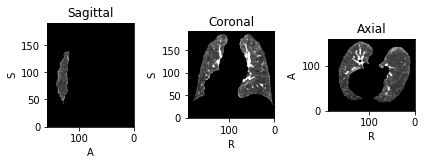

In [55]:
import torchio as tio

tio.Image(tensor = (input_image * mask_moving.cpu())[0,...]).plot()

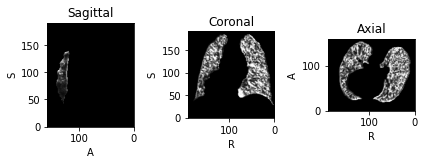

In [51]:
tio.Image(tensor = (output_image * mask_moving.cpu())[0,...]).plot()

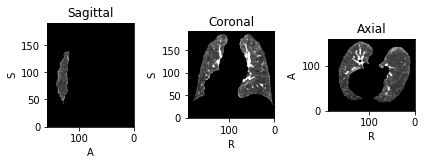

In [54]:
tio.Image(tensor = (fixed_image * mask_fixed.cpu())[0,...]).plot()

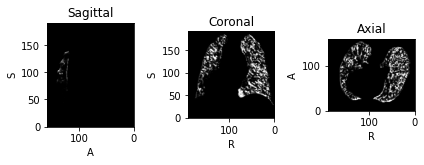

In [47]:
mse_loss = nn.MSELoss(reduction='none')

tio.Image(tensor = (mse_loss(fixed_image, output_image).detach().cpu() * mask_moving.cpu())[0,...]).plot()